
The film industry is a complicated and fascinating multi-billion dollar market. In this notebook, I build a model that uses information about movie trailer viewership (online search trends, etc) and other movie metadata to predict the initial ROI of a movie. The target variable, which I label as "success", is defined as

success = opening weekend revenue/budget

To train model, we only consider movies
* released after 2010 
* released in more than 1000 theaters
* with runtimes > 80 min
* with budget > 
* with production companies that always include the US

In [162]:
%matplotlib inline
from IPython.display import Image, HTML
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary
import datetime
import ast
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import re, time
import warnings, requests
warnings.filterwarnings('ignore')
#plotly.tools.set_credentials_file(username='', api_key='')

sns.set_style('white')
sns.set(font_scale=1.7)
pd.set_option('display.max_colwidth', 50)

## Exploratory Analysis

### Get Data

Let us begin by importing the preprocessed dataset for movies with release year >= 2010. This dataset is an output of the final_data_processing.py script.

In [163]:
df = pd.read_csv('data/df_final.csv')

In [164]:
df.columns

Index(['title', 'num_peaks', 'search_mean', 'search_volume', 'budget',
       'genres', 'original_language', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'weekend_rev',
       'num_theaters', 'success', 'day', 'month', 'holiday', 'year', 'views',
       'likes', 'dislikes', 'dt_main', 'dt_trailers', 'dt_trailers_cat'],
      dtype='object')

In [165]:
df.corr()

,num_peaks,search_mean,search_volume,budget,runtime,weekend_rev,num_theaters,success,holiday,year,views,likes,dislikes,dt_main,dt_trailers
num_peaks,1.000000,0.659220,0.660293,-0.090667,-0.057474,-0.115106,-0.168924,-0.135409,-0.005508,-0.062876,-0.056151,-0.066285,-0.055864,0.164708,0.152927
search_mean,0.659220,1.000000,0.999215,-0.033524,-0.012452,-0.037299,-0.037113,-0.070647,-0.028445,-0.051099,0.003370,-0.028943,-0.026276,0.176107,0.059582
search_volume,0.660293,0.999215,1.000000,-0.027136,-0.012258,-0.033510,-0.033384,-0.070712,-0.029023,-0.046673,0.005787,-0.024723,-0.025353,0.179077,0.058338
budget,-0.090667,-0.033524,-0.027136,1.000000,0.268034,0.638513,0.566100,-0.084779,-0.102136,-0.032068,0.182431,0.221011,0.155985,0.135846,-0.170116
runtime,-0.057474,-0.012452,-0.012258,0.268034,1.000000,0.135838,0.025121,-0.111369,0.098353,0.142127,-0.004470,0.027156,0.004844,-0.015357,-0.031220
weekend_rev,-0.115106,-0.037299,-0.033510,0.638513,0.135838,1.000000,0.703478,0.305695,-0.162299,-0.079691,0.087509,0.144457,0.017771,0.093818,-0.173165
num_theaters,-0.168924,-0.037113,-0.033384,0.566100,0.025121,0.703478,1.000000,0.316171,-0.117101,-0.068394,0.045345,0.082915,0.003385,0.000392,-0.142930
success,-0.135409,-0.070647,-0.070712,-0.084779,-0.111369,0.305695,0.316171,1.000000,0.015419,-0.116226,0.047513,0.032664,-0.012641,-0.034232,0.002489
holiday,-0.005508,-0.028445,-0.029023,-0.102136,0.098353,-0.162299,-0.117101,0.015419,1.000000,0.003123,0.019026,-0.001806,-0.048411,0.050931,-0.026448
year,-0.062876,-0.051099,-0.046673,-0.032068,0.142127,-0.079691,-0.068394,-0.116226,0.003123,1.000000,0.040758,0.130598,0.078493,0.073287,-0.071415


We see that features such as likes, views and dislikes are somewhat correlated with weekend revenue.


### Youtube views, likes, dislikes

Let us plot some distributions after log-transforming

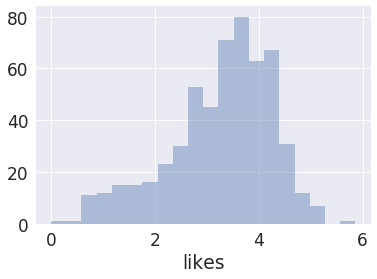

In [166]:
sns.distplot(df.likes.apply(np.log10), kde=False)

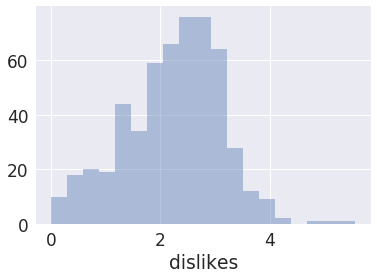

In [167]:
sns.distplot(df[df.dislikes!=0].dislikes.apply(np.log10), kde=False)

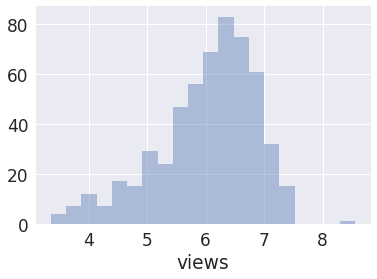

In [168]:
sns.distplot(df[df.views!=0].views.apply(np.log10), kde=False)

In [169]:
df['log_dislikes'] = df[df.dislikes!=0].dislikes.apply(np.log10)
df['log_likes'] = df[df.likes!=0].likes.apply(np.log10)
df['log_views'] = df[df.views!=0].views.apply(np.log10)
df['log_weekend_rev'] = df.weekend_rev.apply(np.log10)

There is a moderate linear correlation between the log(views) and log(weekend_rev)

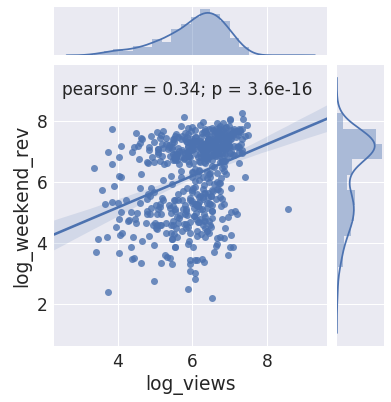

In [170]:

p = sns.jointplot('log_views', 'log_weekend_rev', data=df, kind="reg")

plt.show()

### Production Countries

In [171]:
# create list that includes all countries involved in the movie data set
countries = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
countries.name = 'countries'

countries_df = df.drop('production_countries', axis=1).join(countries)
countries_df = pd.DataFrame(countries_df['countries'].value_counts())
countries_df['country'] = countries_df.index
countries_df.columns = ['num_movies', 'country']
countries_df = countries_df.reset_index().drop('index', axis=1)
countries_df.head(10)
countries_df = countries_df[countries_df['country'] != 'United States of America']

countries_df.head()

,num_movies,country
0,400,['United States of America']
1,24,"['United Kingdom', 'United States of America']"
2,16,"['Canada', 'United States of America']"
3,7,"['France', 'United States of America']"
4,4,"['Australia', 'United States of America']"


### Production Studios

Let us see what are the top production companies (with largest average "success" per movies they produce)

In [172]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies'] = df['production_companies'].apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

com_df = df.drop('production_companies', axis=1).join(s)

com_sum = pd.DataFrame(com_df.groupby('companies')['success'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['success'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['success'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

com_mean.head()

,Average
companies,
Solana Films,9.957961
Haunted Movies,8.847643
Room 101,8.157205
Possessed Pictures,6.002545
Extension 765,5.589596


Seems like studios that produce predominantly horror films have large success rates. We will explore this more below when we look into the genres.

### Release Date

Is there a relation between release dates and success?

In [173]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan
    
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan
    
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

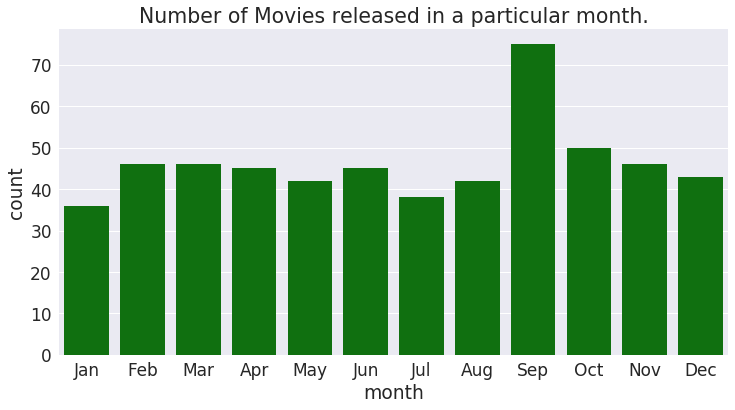

In [174]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df, order=month_order, color='green')

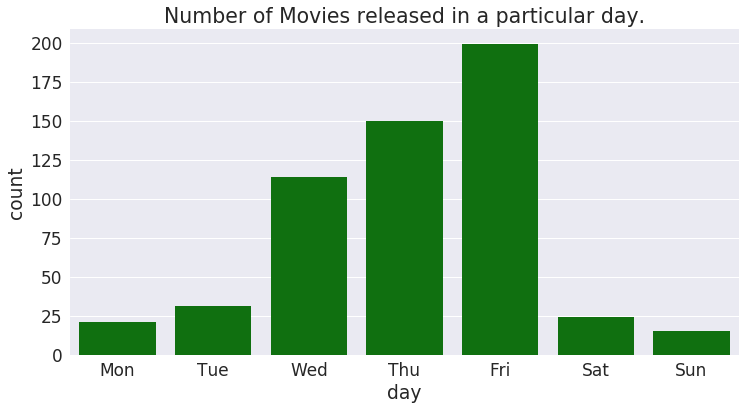

In [175]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular day.")
sns.countplot(x='day', data=df, order=day_order, color='green')

(0, 1.75)

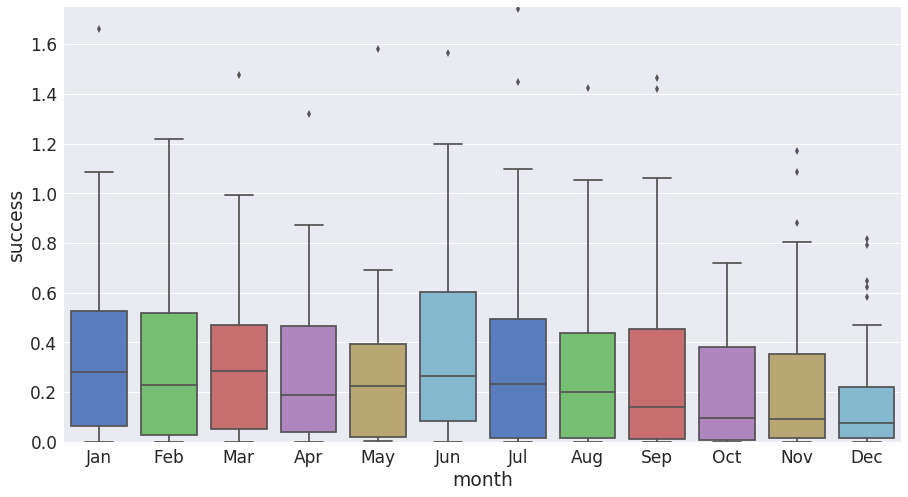

In [176]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='month', y='success', data=df[df['success'].notnull()], palette="muted", ax =ax, order=month_order)
ax.set_ylim([0, 1.75])

Seems like movies released in June do better

### Budget

Let us explore the budget feature. We will consider films which were released in at least 1000 theaters during opening weekend.

In [177]:
df['budget'].describe()

count    5.540000e+02
mean     3.807791e+07
std      4.286572e+07
min      1.030064e+06
25%      9.000000e+06
50%      2.000000e+07
75%      5.000000e+07
max      2.090000e+08
Name: budget, dtype: float64

Text(0.5,0,'Budget Distribution (dollars)')

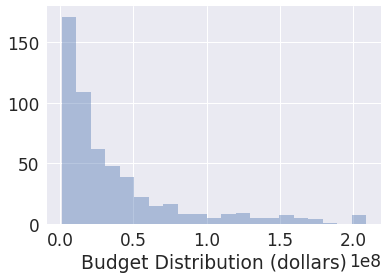

In [178]:
p = sns.distplot(df[df['budget'].notnull()]['budget'], kde=False)
p.set_xlabel('Budget Distribution (dollars)')

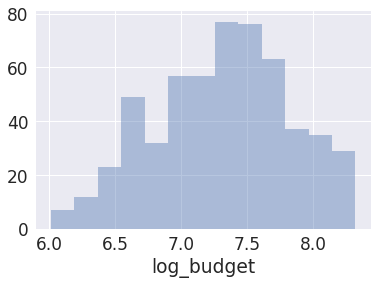

In [179]:
df['log_budget']= df['budget'].apply(np.log10)
sns.distplot(df[df['log_budget'].notnull()]['log_budget'], kde=False)

The log of the budget seems to be sort of normally distributed.

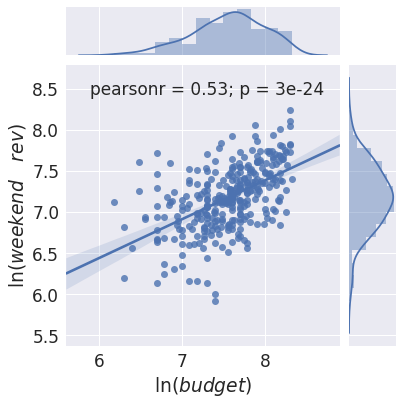

In [180]:
#budget and weekend revenue correlation
p=sns.jointplot('log_budget', 'log_weekend_rev', data=df[df.num_theaters>1000], kind='reg')
p.set_axis_labels(r'$\ln(budget)$', r'$\ln(weekend\quad rev)$')
plt.show()

As expected, budget and weekend revenue are positively correlated.

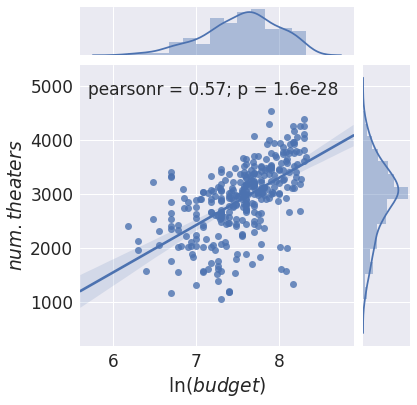

In [181]:
#budget and number of theaters correlation
p=sns.jointplot('log_budget', 'num_theaters', data=df[df.num_theaters>1000], kind='reg')
p.set_axis_labels(r'$\ln(budget)$', r'$num. theaters$')
plt.show()

We see that, in general, large budget films are released in many theaters.

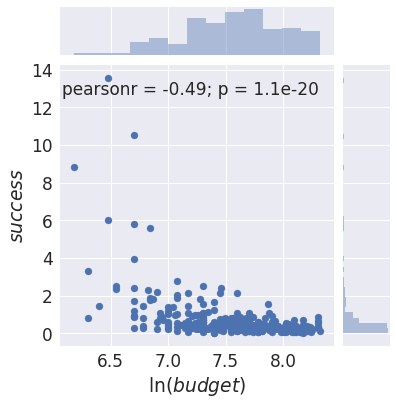

In [182]:
#budget and success correlation
p=sns.jointplot('log_budget', 'success', data=df[df.num_theaters>1000])
p.set_axis_labels(r'$\ln(budget)$', r'$success$')
plt.show()

Surprisingly, there are several movies with smaller budgets that have higher 'success' than average. As we now see, these outliers are mostly horror films.

### Genre

Let us explore the movie genres. Does one genre correlate more with success than the rest?

In [183]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(
    lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

gen_df = df.drop('genres', axis=1).join(s)

gen_df['genre'].value_counts().shape[0]

18

In [184]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,299
1,Comedy,189
2,Thriller,154
3,Action,128
4,Romance,81
5,Adventure,79
6,Crime,66
7,Science Fiction,58
8,Horror,49
9,Family,48


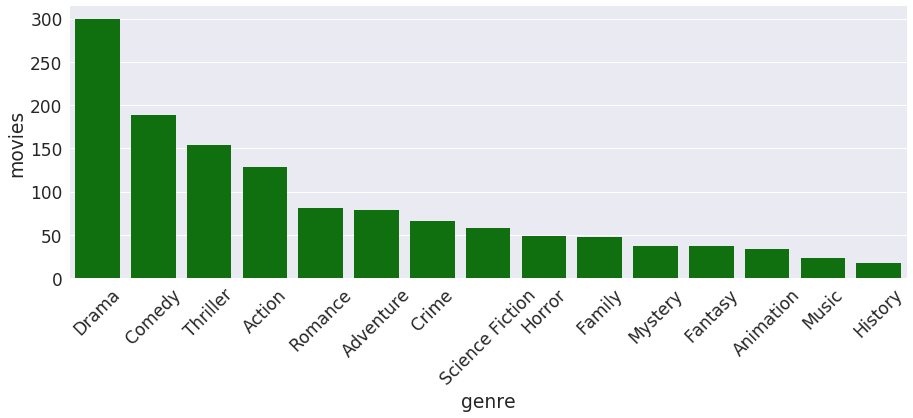

In [185]:
#plot genre distribution 
plt.figure(figsize=(15,5))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15), color='green')
plt.xticks(rotation=45)

plt.show()

In [186]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime',
          'Adventure', 'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

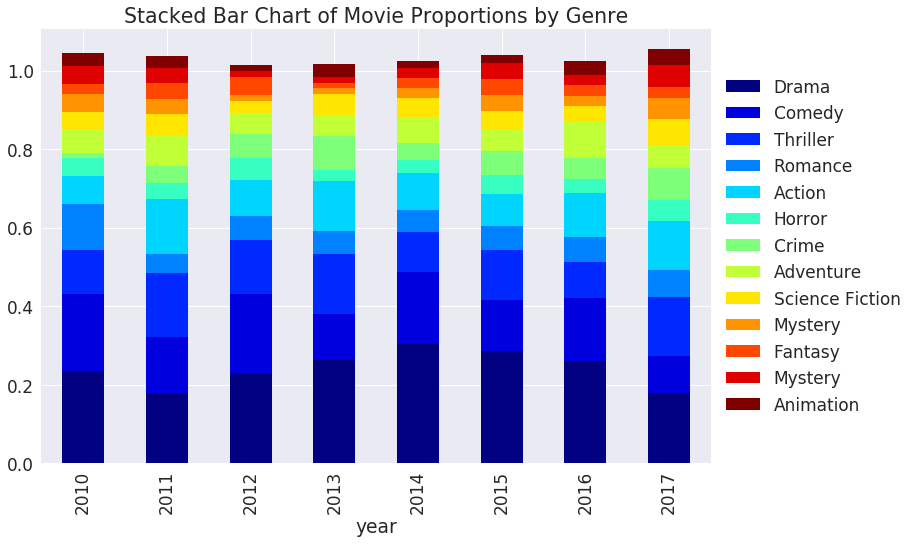

In [187]:
pop_gen_movies = gen_df[(gen_df['genre'].isin(genres))]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Movie Proportions by Genre")
plt.show()

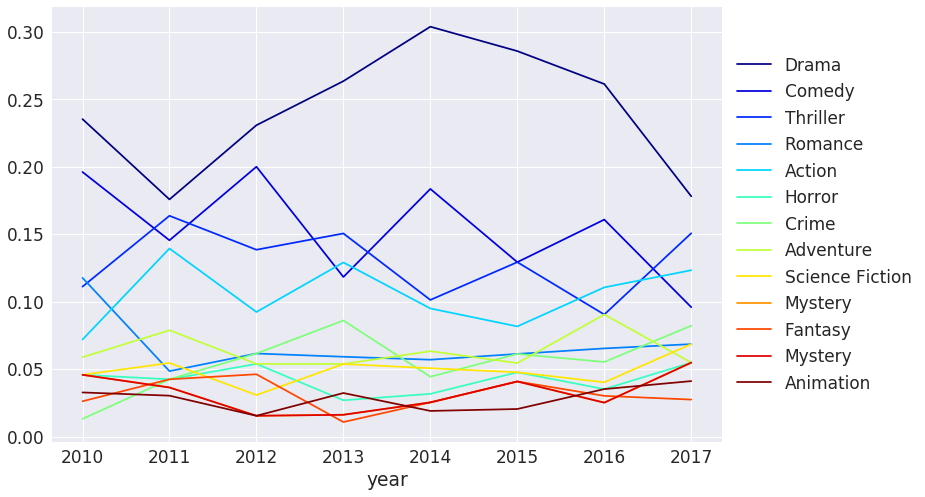

In [188]:
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [189]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

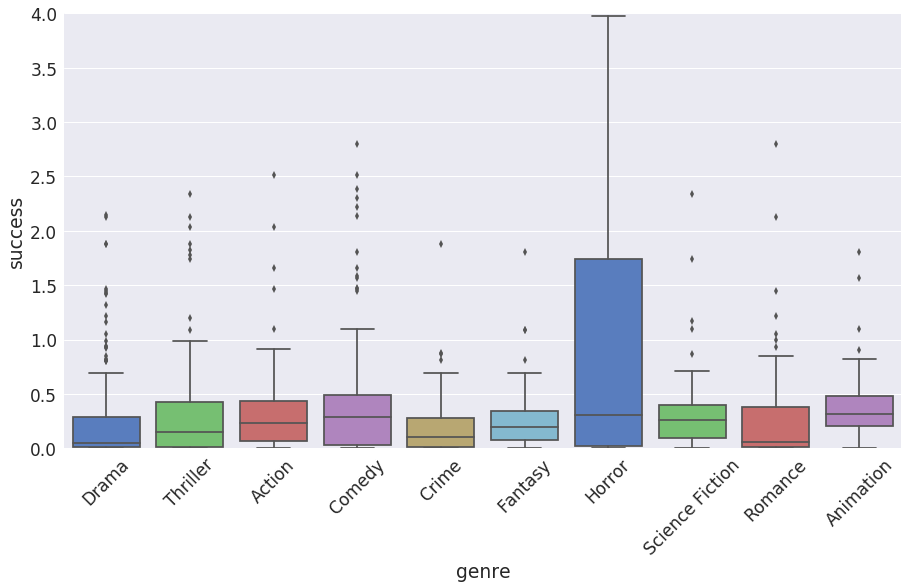

In [190]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='success', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 4])
sns.set(font_scale=1.2)
plt.xticks(rotation=45)
plt.show()

Low budget horror films aparently can lead to success! Indeed, the movie paranormal activity had a budget of 3 million dollars and generated about 40 million on opening weekend:

In [191]:
df.budget[df.title=='Paranormal Activity 2'], df.weekend_rev[df.title=='Paranormal Activity 2'], df.success[df.title=='Paranormal Activity 2']

(359    3000000
 Name: budget, dtype: int64, 359    40678424
 Name: weekend_rev, dtype: int64, 359    13.559475
 Name: success, dtype: float64)

and all of the top 5 movies with largest success are horror films!

In [192]:
pd.DataFrame(df.sort_values('success', ascending=False).title).reset_index(drop=True)[:10]

,title
0,Paranormal Activity 2
1,Paranormal Activity 3
2,Insidious
3,Sinister
4,Paranormal Activity 4
5,Magic Mike
6,Ouija
7,Silent House
8,Think Like a Man
9,Jackass 3D


### runtime

Most movies run for more than 80 minutes. 

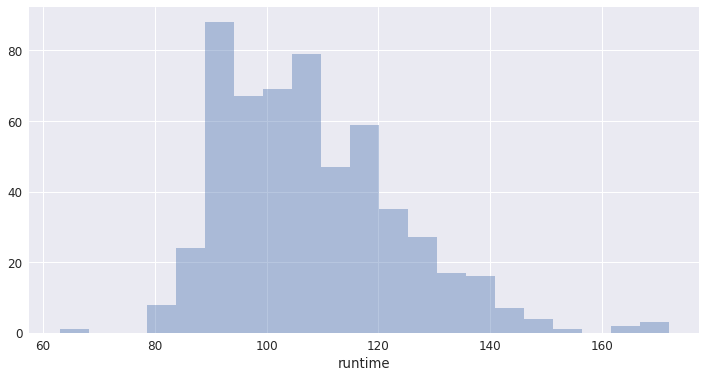

In [193]:
df['runtime'] = df['runtime'].astype('float')
df['runtime'].describe()
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 300) & (df['runtime'] > 0)]['runtime'], kde=False)

## Google trends

Let us explore the google trends data

In [194]:
# import google trends data (for trailer searches)
searches = pd.read_csv('data/searches') #movies released after 2012
searches2010 = pd.read_csv('searches2010')[1:-2] #movies released between 2010-2012
searches = pd.concat([searches2010, searches]).drop_duplicates()

searches.set_index('dates', inplace = True)
searches.drop('dates', inplace = True)

#drop duplicates
searches.reset_index(inplace=True)
searches.drop_duplicates(inplace=True)
searches.set_index('dates', inplace = True)
searches.index = pd.DataFrame(searches.index).apply(
    lambda x: pd.to_datetime(x, format='%Y/%m/%d')).dates

searches.searches = searches.searches.astype(int)

def get_peaks(x,thres, min_dist):
    '''return the indices of the top peaks and their values in the google trends data.
        to be uses when perfoming groupby below'''
    import peakutils
    data = x.values
    baseline_values = peakutils.baseline(data)
    data_without_baseline = data - baseline_values
    peakind = peakutils.indexes(data_without_baseline, thres=thres, min_dist=min_dist)
    dates = x.index
    dates_series = pd.Series(dates)
    data_df = pd.DataFrame(data)
    peak_dates = dates_series[peakind]
    peak_values = data[peakind]
    
    return pd.DataFrame({'peak_dates':peak_dates, 'peak_values':peak_values})

#find the peak index location for each peak
g = searches.groupby('title')
peaks_series = g['searches'].apply(lambda x: get_peaks(x, thres=0.20, min_dist=8))
search_volume = g['searches'].apply(sum)
search_mean = g['searches'].apply(np.mean)

Let us now plot the trends data for the search query for the movie 'gangster squad'

In [195]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy
import peakutils
title = 'Gangster Squad'
dates = searches.groupby('title').groups[title]

def get_movie(title):
    '''function to get google trends data for a particular movie'''
    return searches.loc[searches.title==title]['searches'].copy()

series = pd.Series(get_movie(title).values)
series.set_axis(dates, inplace = True)
indices = list(peaks_series.loc[title].peak_dates.values)

trace = go.Scatter(
    x = dates,
    y= series.values,
    mode='lines',
    name='Search Volume'.format(title)
)

trace2 = go.Scatter(
    x=series[indices].index,
    y=series[indices].values,
    mode='markers',
    marker=dict(
        size=10,
        color='rgb(255,0,0)',
        symbol='cross'
    ),
    name='Maxima'
        
)

data = [trace, trace2]
layout = go.Layout(
    title='Search Volume for \"{} trailer\" on  Google Trends '.format(title),
    xaxis=dict(
        title='The year prior to opening weekend',
        titlefont=dict(
            family='Courier New, monospace',
            size=26,
            color='#black'
        ),
        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=20,
            color='black'
        ),
    ),
    yaxis=dict(
        title='Search Volume (Normalized)',
        titlefont=dict(
            family='Courier New, monospace',
            size=26,
            color='black'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(data, filename=title)
#py.plot(fig, filename='trailers')

We identify two peaks (search surges) corresponding to two different trailers being released for the movie 'gangster squad'. Note that when running the peak detection algorithm, I assume that the height of the second peak must be at least 20% that of the largest peak in order to qualify as a second trailer (note also that the data from google trends comes normalized to 100).

Here is a question that comes to mind: does it matter in general if the largest peak appears first or second?

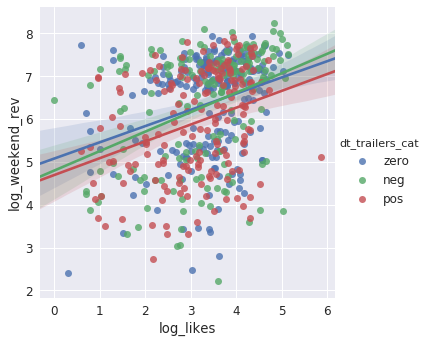

In [196]:
sns.lmplot(x="log_likes", y="log_weekend_rev", hue="dt_trailers_cat", data=df);

In the above plot, the 3 different hues come from the 'dt_trailers_cat' field. They are 
* zero if there is only one peak in the data
* neg if sign(date from larger peak - date from smaller peak)<0
* pos if sign(date from larger peak - date from smaller peak)>0

We see from the plot that movies whose first trailer gets the most attention tend generate more total likes than the other way around. Perhaps this is due to an established fan base or strong marketing strategies prior to the first trailer's release. 

(array([171.,   0.,   0.,   0.,   0., 174.,   0.,   0.,   0., 209.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

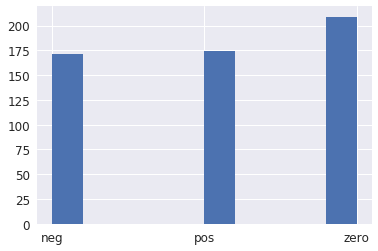

In [197]:
#here is the distribution of dt_trailers_cat
plt.hist(df['dt_trailers_cat'])

The following plot shows that the opening weekend revenue tends  to be higher as well for movies whose first trailer had the most viewership


In [198]:
df.columns

Index(['title', 'num_peaks', 'search_mean', 'search_volume', 'budget',
       'genres', 'original_language', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'weekend_rev',
       'num_theaters', 'success', 'day', 'month', 'holiday', 'year', 'views',
       'likes', 'dislikes', 'dt_main', 'dt_trailers', 'dt_trailers_cat',
       'log_dislikes', 'log_likes', 'log_views', 'log_weekend_rev',
       'log_budget'],
      dtype='object')

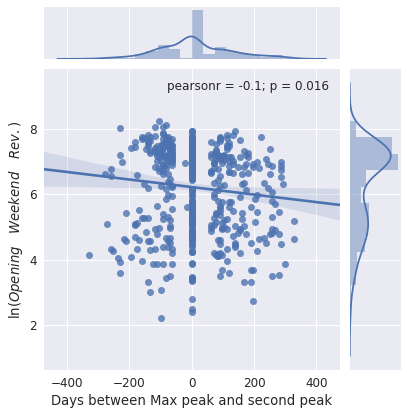

In [200]:
p=sns.jointplot('dt_trailers', 'log_weekend_rev', data=df, kind='reg')
p.set_axis_labels('Days between Max peak and second peak', r'$\ln(Opening\quad Weekend\quad Rev.)$')
plt.show()

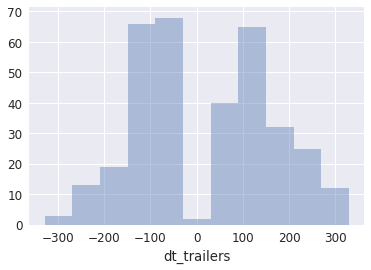

In [130]:
# how many days are there between two trailers?
sns.distplot(df[df['dt_trailers']!=0].dt_trailers, kde=False)

Seems like movie studios tend to release trailers 15 weeks apart.

Text(0.5,0,'Days from best trailer to release date')

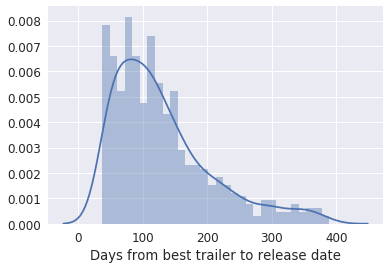

In [201]:
# how many days are there between the best trailer and the relase date?
sns.distplot(df['dt_main'], bins=30)
plt.xlabel('Days from best trailer to release date')

Seems like movie trailers are typically released about 3 months prior to release date.

## Models

In [250]:
df = pd.read_csv('data/df_final.csv')
#df= df[df.success<=1]
df= df[df.budget>=10000000]
df = df[df.num_peaks<3]
df = df[df.runtime>80]

In [251]:
#df['log_dislikes'] = df[df.dislikes!=0].dislikes.apply(np.log10)
#df = df.drop(['dislikes'], axis=1)
#df['log_likes'] = df[df.likes!=0].likes.apply(np.log10)
#df = df.drop(['likes'], axis=1)
df['log_views'] = df[df.views!=0].views.apply(np.log10)
df = df.drop(['views'], axis=1)
df['log_budget'] = df[df.budget!=0].budget.apply(np.log10)
df = df.drop(['budget'], axis=1)
#df['log_search_volume'] = df[df.search_volume!=0].search_volume.apply(np.log10)
#df = df.drop(['search_volume'], axis=1)

In [252]:
#df = df.drop(['search_mean', 'release_date', 'weekend_rev', 'dt_trailers_cat', 'runtime'], axis=1)
df = df.drop(['search_mean', 'release_date', 'weekend_rev', 'dt_trailers', 'runtime'], axis=1)

In [253]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)
genres_train = gen_df['genre'].drop_duplicates()

In [254]:
def feature_engineering(df):
    for genre in genres_train:
        df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 if genre in x else 0)
    df['genres'] = df['genres'].apply(lambda x: len(x))    
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    #df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov', 'Dec'] else 0)
    df = df.drop('month', axis=1)
    df['neg'] = pd.get_dummies(df.dt_trailers_cat).neg
    df['neg'] = pd.get_dummies(df.dt_trailers_cat).pos
    df['zero'] = pd.get_dummies(df.dt_trailers_cat).zero
    df.drop('dt_trailers_cat', axis=1)
    df = pd.get_dummies(df, prefix='is')
    #df['search_proxy'] = df['views_proxy']*df['search_volume']*df['likes']/(df['likes'] +df['dislikes'])
    #df.drop(['likes', 'dislikes', 'views_proxy', 'search_volume'], axis=1, inplace=True)
    #df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    return df

In [255]:
X, y = df.drop('success', axis=1), df['success']

In [256]:
df.columns

Index(['title', 'num_peaks', 'search_volume', 'genres', 'original_language',
       'production_companies', 'production_countries', 'num_theaters',
       'success', 'day', 'month', 'holiday', 'year', 'likes', 'dislikes',
       'dt_main', 'dt_trailers_cat', 'log_views', 'log_budget'],
      dtype='object')

In [257]:
X = feature_engineering(X)
features = X.columns

In [258]:
num_vars = ['num_peaks', 'search_volume', 'log_views', 'likes', 'dislikes', 'num_theaters', 'dt_main', 'log_budget']
#num_vars = ['num_peaks', 'log_search_volume',  'log_likes', 'log_dislikes', 'log_budget', 'num_theaters', 'dt_main']

# normalize the dataset
#scaler =StandardScaler()
#X[num_vars]= scaler.fit_transform(X[num_vars])

In [259]:
X = np.nan_to_num(X)

In [260]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

SyntaxError: unexpected EOF while parsing (<ipython-input-260-74061642f636>, line 7)

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [262]:
#X_train, X_test, X_test_holdout = np.split(X.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [263]:
from sklearn.model_selection import cross_val_predict, GridSearchCV
reg = XGBRegressor( n_estimators=100)
y_pred = cross_val_predict(reg, X, y, cv=10)

reg.fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

0.9411940191012254
0.2062517098233677


In [228]:
from sklearn.model_selection import cross_val_predict, GridSearchCV
reg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=330, subsample=1,
                                criterion='friedman_mse', min_samples_split=2, min_samples_leaf=2, 
                                min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0)
y_pred = cross_val_predict(reg, X, y, cv=10)

reg.fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

0.9999778780119358
0.8898957882619575


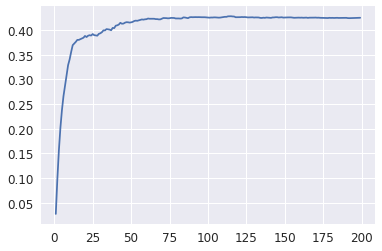

In [265]:

params = list(range(1,200))
clf = GridSearchCV(reg, {'n_estimators': params})
_=clf.fit(X, y)
plt.plot(params, clf.cv_results_['mean_test_score'])

In [229]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

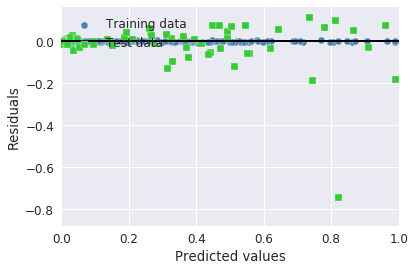

In [230]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([0, 1])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

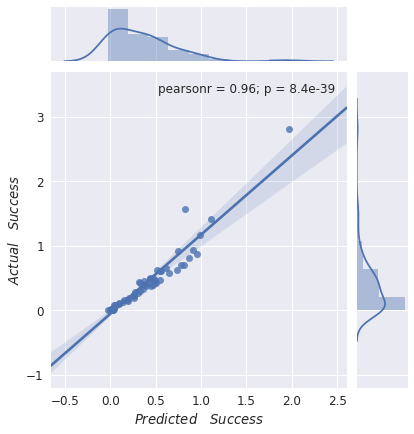

In [231]:
y_pred = reg.predict(X_test)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
p=sns.jointplot(y_pred, y_test, kind='reg')
p.set_axis_labels(
    r'$ Predicted\quad Success$', r'$ Actual\quad Success$')

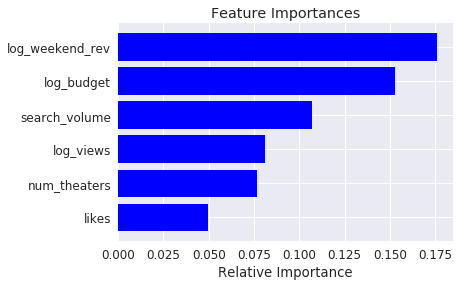

In [232]:
importances = reg.feature_importances_
indices = np.argsort(importances)[-6:]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
#Random forest
# from sklearn.ensemble import RandomForestRegressor

# forest = RandomForestRegressor(n_estimators=50, min_samples_split=4,
#                                criterion='mse', 
#                                random_state=1, 
#                                n_jobs=-1)
# forest.fit(X_train, y_train)
# y_train_pred = forest.predict(X_train)
# y_test_pred = forest.predict(X_test)

# print('MSE train: %.3f, test: %.3f' % (
#         mean_squared_error(y_train, y_train_pred),
#         mean_squared_error(y_test, y_test_pred)))
# print('R^2 train: %.3f, test: %.3f' % (
#         r2_score(y_train, y_train_pred),
#         r2_score(y_test, y_test_pred)))